# LearnedDistribution and Redistributor

In [ ]:
# WE STILL HAVE A PROBLEM when we know the a, b exactly, e.g. with real images [0, 1] or [0, 255]
# and at the same time, the training data contains 0 and 1. We are not able to use a, b = 0, 1 because
# of condition that a and b must be strictly smaller / bigger than min / max.

# Another thing to look at is the method of making lattice vals unique.
# Do we need this at all, should we decouple the function from Learned distribution?
# Are the deterministic methods even necessary or is just random noise enough? (edgecases)

# In case user is learning a discrete distribution such as a real image
# shall we try to make the PDF look like something meaningful or do we
# settle with the fact it does not make sense for discrete distributions?
# Shall we even return a PDF? Or shall we drop it whatsoever and just return None?

In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import time
import numpy as np
import matplotlib.pyplot as plt
from redistributor import Redistributor as R
from redistributor import LearnedDistribution as L
from redistributor import plot_cdf_ppf_pdf as cpp

## Demostrating LearnedDistribution

In [68]:
# Configure the size of the random data
GB = 0.10
dtype = np.float64
size = int(GB * 1024**3 / dtype().itemsize)

In [87]:
# Source distribution DGAMMA
from scipy.stats import dgamma
dist = dgamma(7.)
dist.name = 'Dgamma'
x = dist.rvs(size=size, random_state=42).astype(dtype)
a = None # np.floor(x.min())
b = None # np.ceil(x.max())
print('Input data generated.')

Input data generated.


In [77]:
# Source distribution UNIFORM
from scipy.stats import uniform
dist = uniform(loc=0., scale=1.)
dist.name = 'Uniform'
x = dist.rvs(size=size).astype(dtype)
a = None # np.floor(x.min())
b = None # np.ceil(x.max())
print('Input data generated.')

Input data generated.


In [69]:
# Source distribution GAUSSIAN
from scipy.stats import norm
dist = norm(loc=0., scale=1.)
dist.name = 'Gaussian'
x = dist.rvs(size=size).astype(dtype)
a = None #np.floor(x.min())
b = None #np.ceil(x.max())
print('Input data generated.')

Input data generated.


In [88]:
# Learned distribution config
conf = {
    'bins': None,
    'keep_x_unchanged': True,
    'subsample_x': None,
    'assume_sorted': False,
    'fill_value': 'auto',
    'bounds_error': 'warn',
    'dupl_method': 'spread',
    'seed': 42,
    'name': 'LearnedDistribution',
}

CPU times: user 793 ms, sys: 7.31 ms, total: 801 ms
Wall time: 800 ms
LearnedDistribution on interval (None, None) from Dgamma


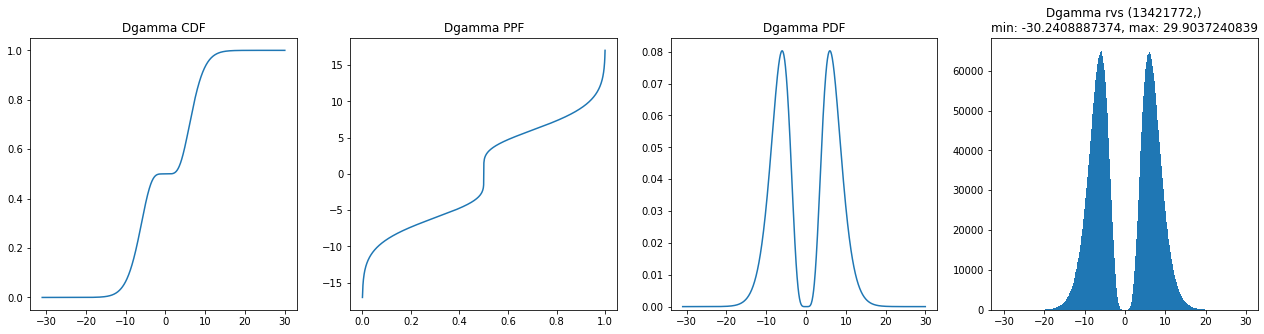

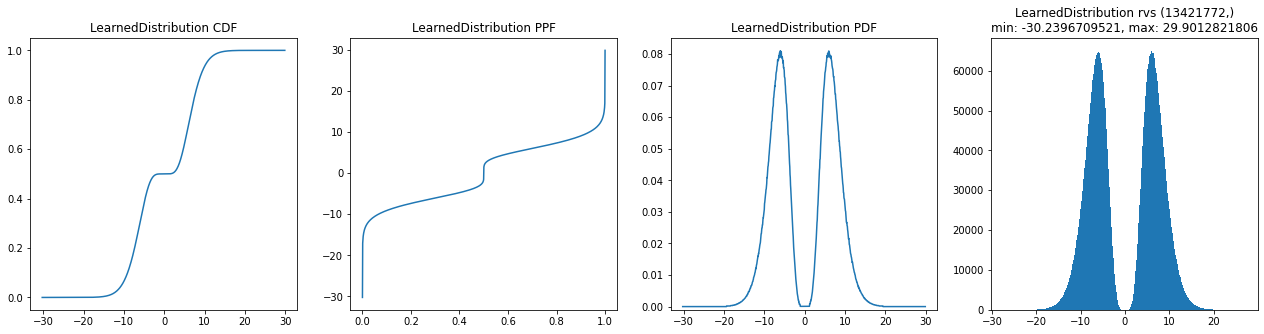

In [89]:
%time learned = L(x, a, b, **conf)
print(f'{learned.name} on interval ({learned.a}, {learned.b}) from {dist.name}')

# Show CDF, PPF, PDF and histogram of dist
plt.figure(figsize=(22,5))
cpp(dist, a=np.floor(x.min()), b=np.ceil(x.max()), v=0, w=1, bins=1000, 
    rows=1, cols=4, figsize=None)
plt.subplot(1, 4, 4)
plt.title(f'{dist.name} rvs {x.shape}\nmin: {x.min():.10f}, max: {x.max():.10f}')
plt.hist(x, bins=1000)
plt.xlim(a, b)
plt.show(); plt.close()

# Show CDF, PPF, PDF and histogram of learned
plt.figure(figsize=(22,5))
s = learned.rvs(x.size)
cpp(learned, bins=1000, rows=1, cols=4, figsize=None)
plt.subplot(1, 4, 4)
plt.title(f'{learned.name} rvs {s.shape}\nmin: {s.min():.10f}, max: {s.max():.10f}')
plt.hist(x, bins=1000)
plt.xlim(*learned._get_support())
plt.show(); plt.close()

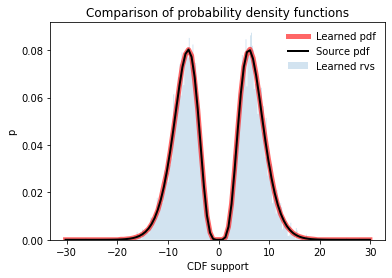

In [90]:
fig, ax = plt.subplots(1, 1)
plt.title('Comparison of probability density functions')

# Display the probability density function (PDF):
x = np.linspace(*learned._get_support(), 100)
ax.plot(x, learned.pdf(x), 'r-', lw=5, alpha=0.6, label='Learned pdf')
ax.plot(x, dist.pdf(x), 'k-', lw=2, label='Source pdf')
plt.xlabel('CDF support')
plt.ylabel('p')

# Compare the PDFs with histogram of random sample:
rs = learned.rvs(size=10000)
ax.hist(rs, bins=300, density=True, histtype='stepfilled', alpha=0.2, label='Learned rvs')

ax.legend(loc='best', frameon=False)
plt.show()

/home/paloha/Documents/Work/Research/Projects/Projects/redistributor/redistributor.py:722: UserWarning: Adjusting 95.24000000000001% non-unique lattice values. Avoid learning discrete distributions.
  warnings.warn(


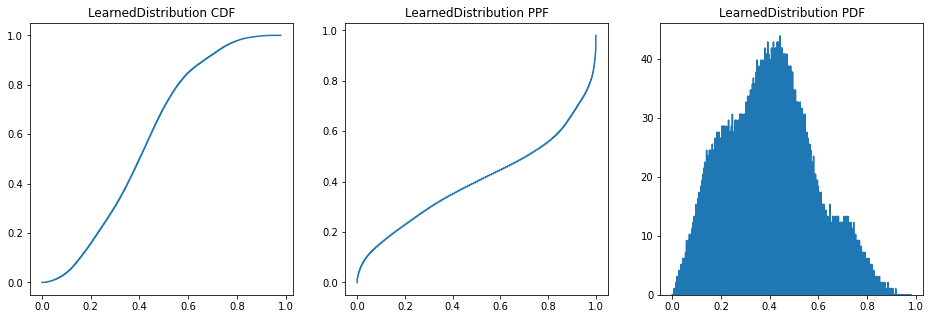

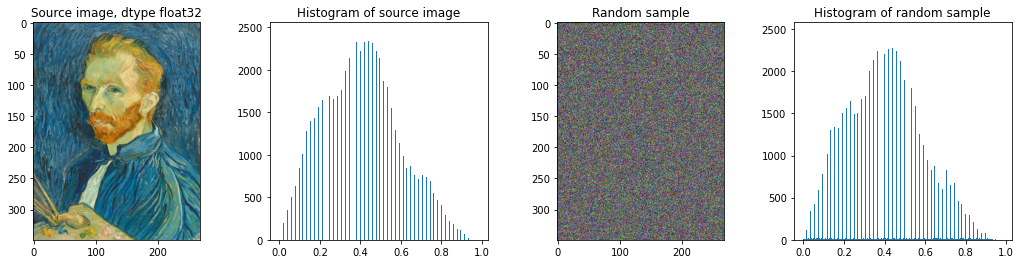

In [289]:
# Learn a distribution of an image
x = plt.imread('aux/experiments/MatchColors/portraits/vangogh.png')
a = None
b = None

learned = L(x, a, b, bins=None, dupl_method='cluster')
cpp(learned)

# Random sample
plt.figure(figsize=(18, 4))
plt.subplot(141)
plt.title(f'Source image, dtype {x.dtype}')
plt.imshow(x)

plt.subplot(142)
plt.title('Histogram of source image')
plt.hist(x.ravel(), bins=1000)

plt.subplot(143)
plt.title('Random sample')
s = learned.rvs(x.size)
plt.imshow(s.reshape(x.shape))

plt.subplot(144)
plt.title('Histogram of random sample')
plt.hist(s, bins=1000)
plt.show()

Text(0.5, 1.0, 'Smoothed PDF 10000, 9951')

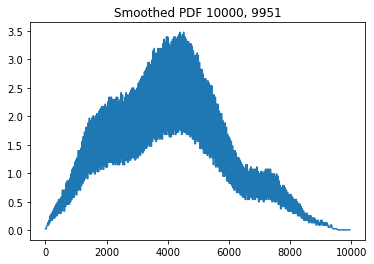

In [100]:
# Shall we use this to smooth the pdf?
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

ss = learned.pdf(np.linspace(*learned._get_support(), learned.bins * 2))
ma = moving_average(ss, learned.bins//100)

plt.plot(ma)
plt.title(f'Smoothed PDF {ss.size}, {ma.size}')

/home/paloha/Documents/Work/Research/Projects/Projects/redistributor/redistributor.py:722: UserWarning: Adjusting 99.91090393305679% non-unique lattice values. Avoid learning discrete distributions.
  warnings.warn(
/home/paloha/Documents/Work/Research/Projects/Projects/redistributor/redistributor.py:727: UserWarning: Array has too many duplicates (280346) to use the deterministic algorithm. Solving some or all by adding small random noise.
  warnings.warn((
/home/paloha/Documents/Work/Research/Projects/Projects/redistributor/redistributor.py:722: UserWarning: Adjusting 2.467604670059445% non-unique lattice values. Avoid learning discrete distributions.
  warnings.warn(
/home/paloha/Documents/Work/Research/Projects/Projects/redistributor/redistributor.py:722: UserWarning: Adjusting 0.04811187614933926% non-unique lattice values. Avoid learning discrete distributions.
  warnings.warn(
/home/paloha/Documents/Work/Research/Projects/Projects/redistributor/redistributor.py:722: UserWarning:

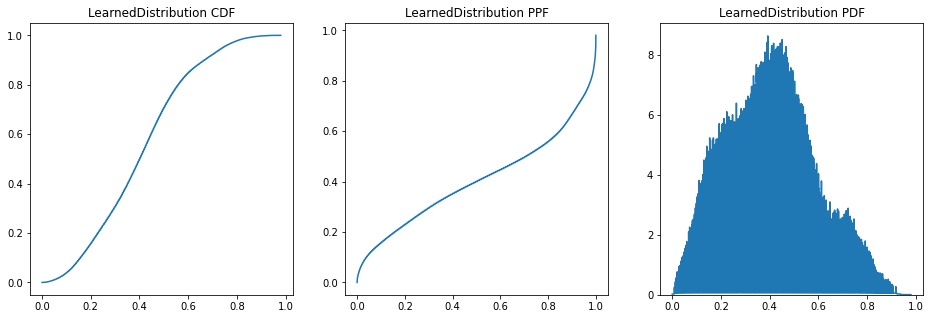

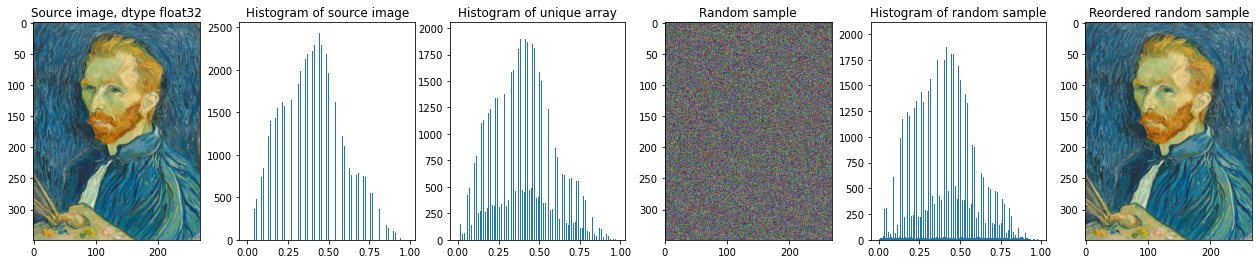

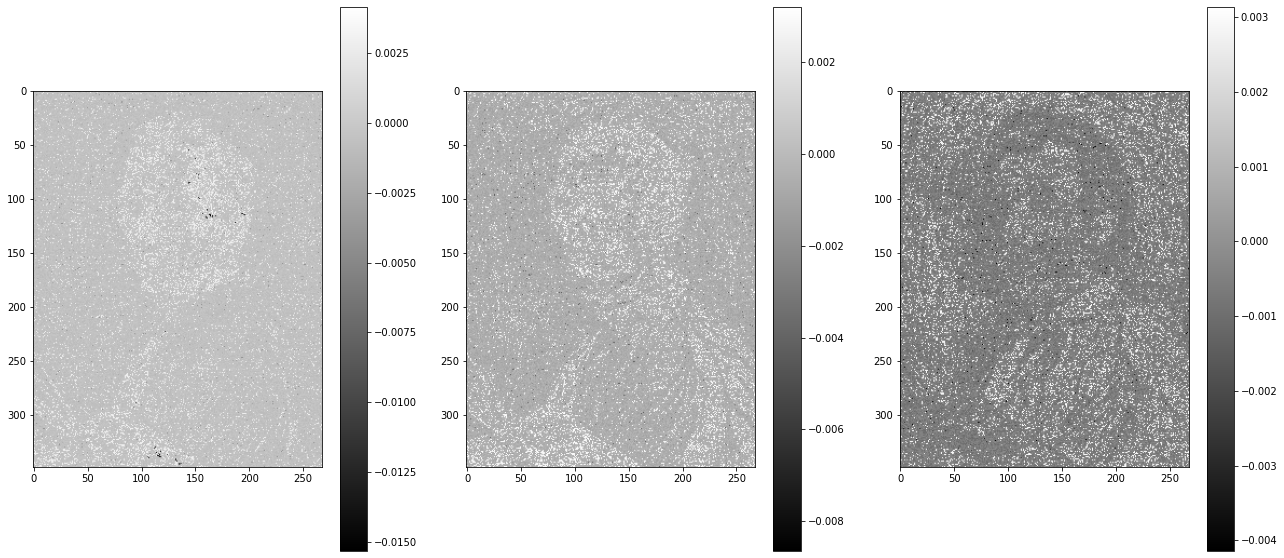

In [279]:
# Showing the effects of "make unique()" on error
from redistributor import make_unique
from numpy.random import default_rng

# Load an image
# x = toGray(plt.imread('aux/experiments/MatchColors/portraits/vangogh.png'))
x = plt.imread('aux/experiments/MatchColors/portraits/vangogh.png')


# Argument which sorts x
i = np.argsort(x.ravel())

# Make its values unique (fake a continuous distribution)
u = make_unique(x.ravel()[i], random_state=default_rng(42), mode='cluster')

# Learn the distribution from unique u (method keep as u should be unique)
learned = L(u, a=None, b=None, bins=None, dupl_method='keep')

# Show what we learned
cpp(learned)

##########
# Plotting
##########

plt.figure(figsize=(22, 4))
plt.subplot(161)
plt.title(f'Source image, dtype {x.dtype}')
plt.imshow(x)

plt.subplot(162)
plt.title('Histogram of source image')
plt.hist(x.ravel(), bins=1000)

plt.subplot(163)
plt.title('Histogram of unique array')
plt.hist(u, bins=1000)

plt.subplot(164)
plt.title('Random sample')
s = learned.rvs(x.size)
plt.imshow(s.reshape(x.shape))

plt.subplot(165)
plt.title('Histogram of random sample')
plt.hist(s, bins=1000)

plt.subplot(166)
plt.title('Reordered random sample')
inversed = np.sort(s)[np.argsort(i)].reshape(x.shape)
plt.imshow(inversed)

channels = len(x.shape)
error = x - inversed
plt.figure(figsize=((22/3)*channels, 10))
for i, ch in enumerate(range(channels)):
    plt.subplot(1, channels, i+1)
    plt.imshow(error[:,:,i])
    plt.colorbar()

# Redistributor

## Demonstrating Redistributor

In [280]:
# Configure the size of the random data
GB = 0.1
dtype = np.float64
size = int(GB * 1024**3 / dtype().itemsize)

In [281]:
# Source distribution 
from scipy.stats import dgamma
source_name = 'Learned dgamma'
x = dgamma(5.).rvs(size=size).astype(dtype)
source_a = None # np.floor(x.min())
source_b = None # np.ceil(x.max())
print('Source data generated.')

Source data generated.


In [282]:
# Target distribution
from scipy.stats import norm
target_name = 'Learned gaussian'
y = norm(loc=0., scale=1.).rvs(size=size).astype(dtype)
target_a, target_b = None, None # np.floor(y.min()), np.ceil(y.max()) 
print('Target data generated.')

Target data generated.


Distributions learned and Redistributor ready.
KstestResult(statistic=0.4621078489773466, pvalue=0.0)


/home/paloha/Documents/Work/Research/Projects/Projects/redistributor/redistributor.py:576: UserWarning: 317 out of 2000 values in x_new are below the interpolation range. Read the docs of `fill_value` and `bounds_error` to manage the behavior. Mapping the invalid values to value: [7.45058049e-08].
  warnings.warn(m)
/home/paloha/Documents/Work/Research/Projects/Projects/redistributor/redistributor.py:586: UserWarning: 354 out of 2000 values in x_new are above the interpolation range. Read the docs of `fill_value` and `bounds_error` to manage the behavior. Mapping the invalid values to value: [0.99999993].
  warnings.warn(m)


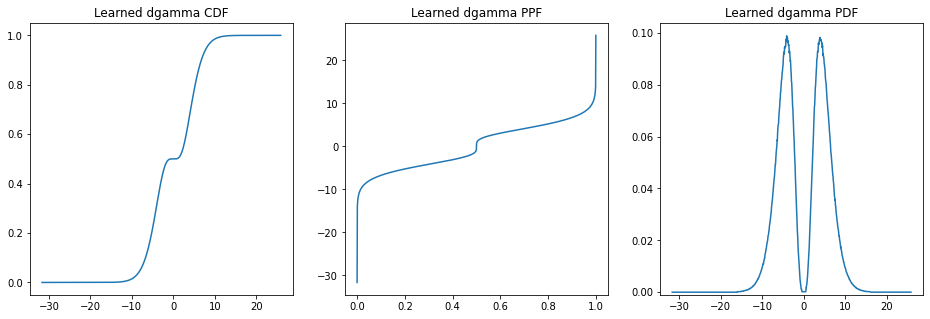

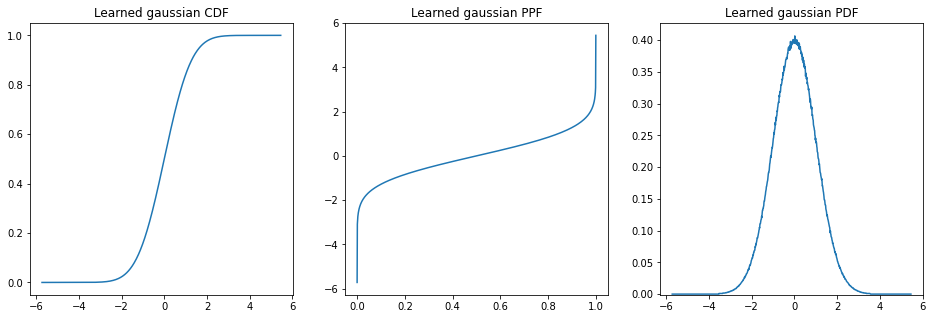

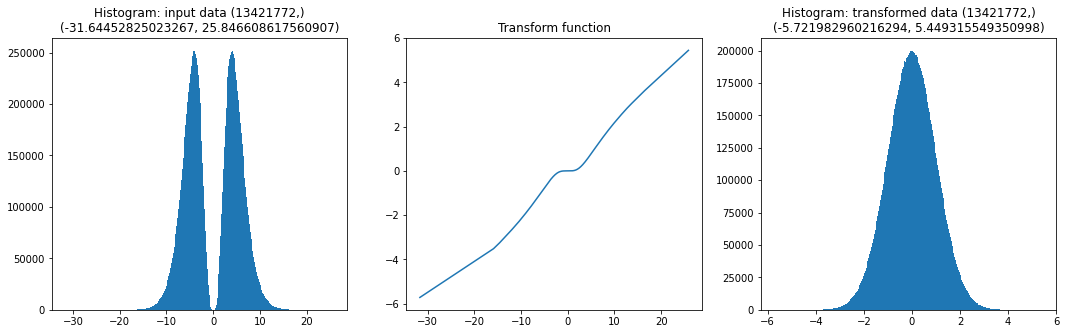

In [283]:
# Make an instance of Redistributor
r = R(
    source=L(x, source_a, source_b, name=source_name, subsample_x=None, dupl_method='spread'),
    target=L(y, target_a, target_b, name=target_name, subsample_x=None, dupl_method='spread'))
print('Distributions learned and Redistributor ready.')

# Use Kolmogorov-Smirnov test to find out whether it is even necessary to redistribute
print(r.kstest(n=2000)) # p-value: 0 = redistribute, 1 = no need to

# Plot the learned functions
cpp(r.source, bins=1000)
cpp(r.target, bins=1000)

# Plot the histogram of the input data before transformation
plt.figure(figsize=(18, 5))
plt.subplot(131)
plt.hist(x, bins=300)
plt.title(f'Histogram: input data {x.shape}\n{x.min(), x.max()}')
plt.xlim(source_a, source_b)

# Plot the transform function
plt.subplot(132)
r.plot_transform_function(newfig=False)

# Plot the histogram of the transformed data
t = r.transform(x)
plt.subplot(133)
plt.hist(t, bins=300)
plt.title(f'Histogram: transformed data {t.shape}\n{t.min(), t.max()}')
plt.show()

# Matching colors

Matt's colors to Gogh's colors
Matt's colors to Ian's colors
Matt's grays to Ian's grays


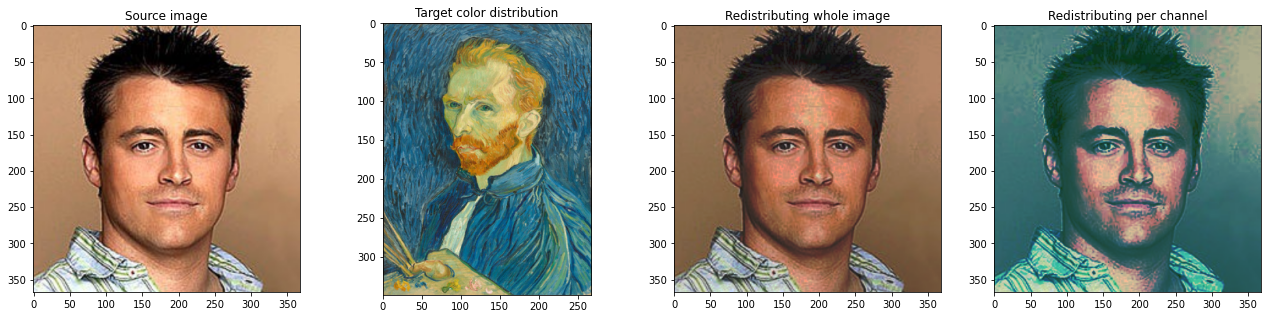

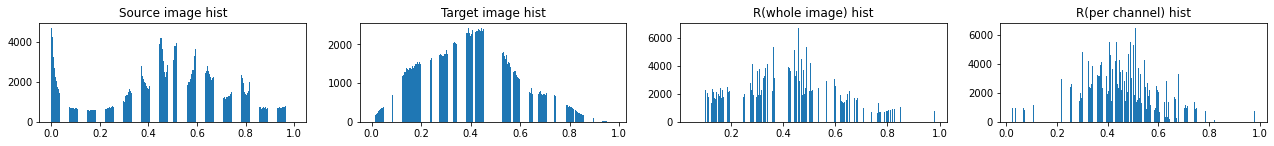

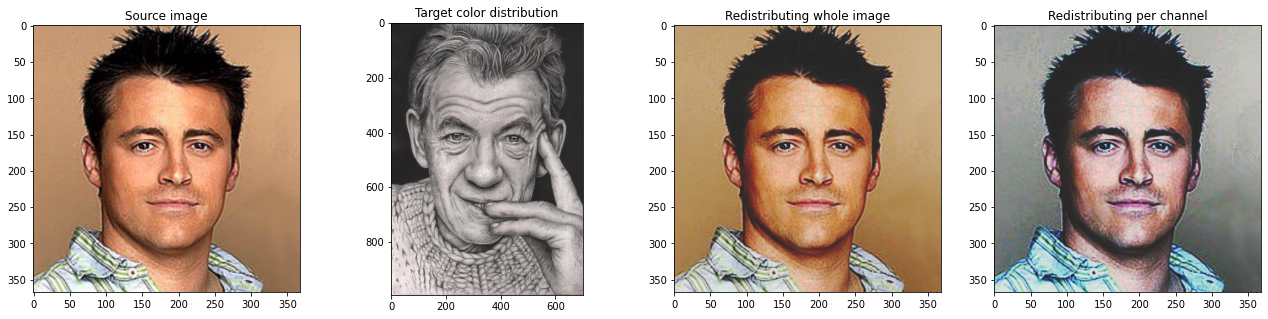

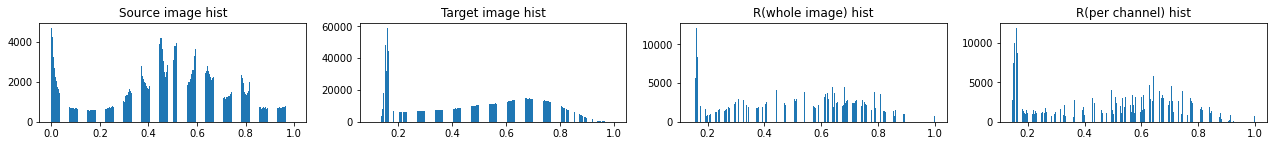

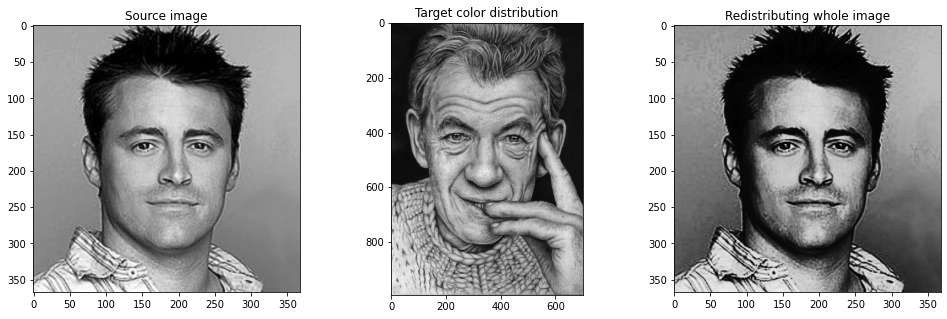

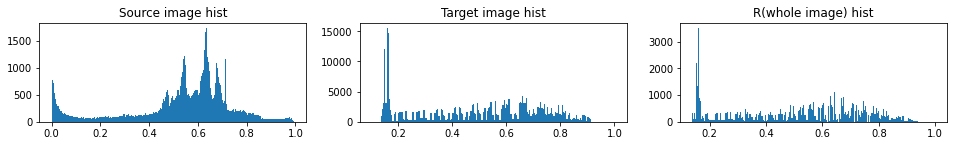

In [290]:
# https://towardsdatascience.com/neural-style-transfer-using-vgg-model-ff0f9757aafc
# https://www.deviantart.com/pen-tacular-artist/art/Ian-Mckellen-graphite-portrait-369296223

src = plt.imread('aux/experiments/MatchColors/portraits/matt.png')
dst = plt.imread('aux/experiments/MatchColors/portraits/vangogh.png')
dst2 = plt.imread('aux/experiments/MatchColors/portraits/ian.png')

shape = src.shape
sR = (slice(None), slice(None), 0)
sG = (slice(None), slice(None), 1)
sB = (slice(None), slice(None), 2)

# # https://www.dynamsoft.com/blog/insights/image-processing/image-processing-101-color-space-conversion/
toGray = lambda x: 0.299 * x[sR] + 0.587 *x[sG] + 0.114 * x[sB]  


def show(s, d, gray=False):
    if gray:
        s = toGray(s)
        d = toGray(d)
        plt.gray()
    
    plt.figure(figsize=(22,11))
    #############
    # Image space
    #############
    
    plt.subplot(241)
    plt.title('Source image')
    plt.imshow(s)

    plt.subplot(242)
    plt.title('Target color distribution')
    plt.imshow(d)

    # All channels at once
    o1 = R(source=L(s, dupl_method='keep'), target=L(d, dupl_method='keep')).transform(s)

    plt.subplot(243)
    plt.title('Redistributing whole image')
    plt.imshow(o1)

    if not gray:
        # Channels separately
        o2 = np.zeros_like(s)
        o2[:,:,0] = R(source=L(s[sR], dupl_method='keep'), 
                      target=L(d[sR], dupl_method='keep')).transform(s[sR])
        o2[:,:,1] = R(source=L(s[sG], dupl_method='keep'), 
                      target=L(d[sG], dupl_method='keep')).transform(s[sG])
        o2[:,:,2] = R(source=L(s[sB], dupl_method='keep'), 
                      target=L(d[sB], dupl_method='keep')).transform(s[sB])

        plt.subplot(244)
        plt.title('Redistributing per channel')
        plt.imshow(o2)
    
    #################
    # Histogram space
    #################
    
    plt.figure(figsize=(22,4))
    plt.subplot(241)
    plt.title('Source image hist')
    plt.hist(s.ravel(), bins=512)
    
    plt.subplot(242)
    plt.title('Target image hist')
    plt.hist(d.ravel(), bins=512)
    
    plt.subplot(243)
    plt.title('R(whole image) hist')
    plt.hist(o1.ravel(), bins=512)
    
    if not gray:
        plt.subplot(244)
        plt.title('R(per channel) hist')
        plt.hist(o2.ravel(), bins=512)
    
print("Matt's colors to Gogh's colors")
show(src, dst)

print("Matt's colors to Ian's colors")
show(src, dst2)

print("Matt's grays to Ian's grays")
show(src, dst2, gray=True)


/home/paloha/Documents/Work/Research/Projects/Projects/redistributor/redistributor.py:722: UserWarning: Adjusting 94.92% non-unique lattice values. Avoid learning discrete distributions.
  warnings.warn(


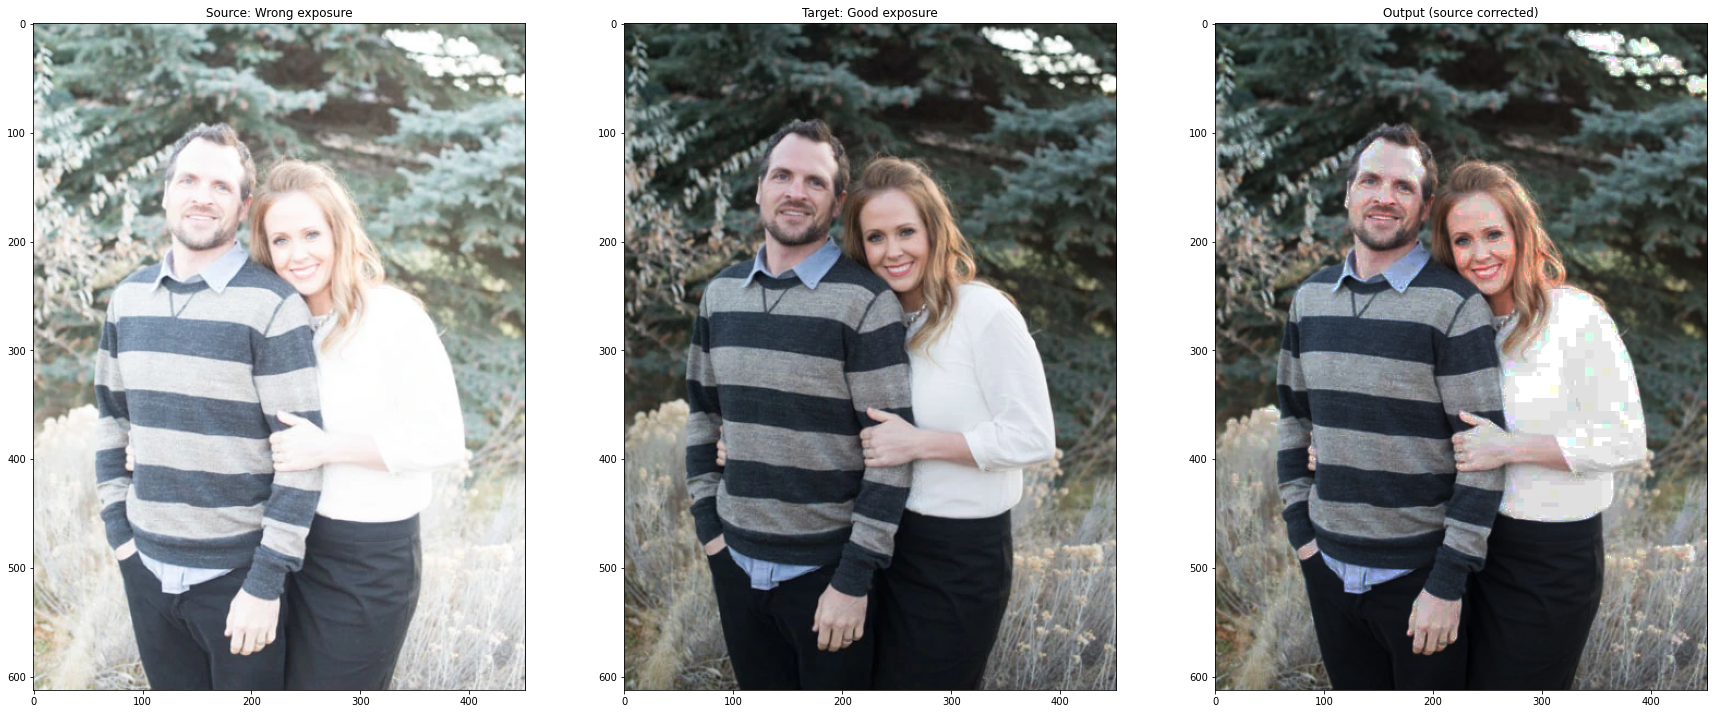

In [286]:
# https://www.lightroompresets.com/blogs/pretty-presets-blog/16546692-match-total-exposure-aka-the-trick-that-could-have-saved-me-hours
src = plt.imread('aux/experiments/MatchColors/couple/2.png')  # Overexposed real image
# src = plt.imread('aux/experiments/StyleTransfer/couple/3.png') # image messed up in photoshop
dst = plt.imread('aux/experiments/MatchColors/couple/1.png')  # Well exposed real image
shape = src.shape

# Applying redistribution only on a region of interest
roi = slice(None, None)
roi_shape = shape
# roi = (slice(100, 300), slice(100,300), slice(None, None))

# # Channels separately
# out = src.copy()
# out[roi][:,:,0] = Redistributor(
#     source=LearnedDistribution(src[roi][:,:,0].ravel()), 
#     target=LearnedDistribution(dst[roi][:,:,0].ravel(), bins=int(1e4), a=None, b=None)
# ).transform(src[roi][:,:,0].ravel()).reshape(roi_shape[:-1])


# out[roi][:,:,1] = Redistributor(
#     source=LearnedDistribution(src[roi][:,:,1].ravel()), 
#     target=LearnedDistribution(dst[roi][:,:,1].ravel(), bins=int(1e4), a=None, b=None)
# ).transform(src[roi][:,:,1].ravel()).reshape(roi_shape[:-1])


# out[roi][:,:,2] = Redistributor(
#     source=LearnedDistribution(src[roi][:,:,2].ravel()), 
#     target=LearnedDistribution(dst[roi][:,:,2].ravel(), bins=int(1e4), a=None, b=None)
# ).transform(src[roi][:,:,2].ravel()).reshape(roi_shape[:-1])


eps = None
a = None if eps is None else 0 - eps
b = None if eps is None else 1 + eps

# All channels at once
r = R(source=L(src.ravel(), a=a, b=b, dupl_method='keep'), 
      target=L(dst.ravel(), a=a, b=b, dupl_method='spread'))
out = r.transform(src.ravel()).reshape(shape)

plt.figure(figsize=(30,15))
plt.subplot(131)
plt.title('Source: Wrong exposure')
plt.imshow(src)
plt.subplot(132)
plt.title('Target: Good exposure')
plt.imshow(dst)
plt.subplot(133)
plt.title('Output (source corrected)')
plt.imshow(out)

In [ ]:
# Here we need to look into the methods of managing duplicate values
# If we use 'keep' or 'cluster' in the previous 'couple' example, 
# the learned pdf bellow will not match

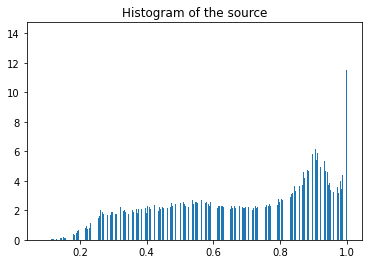

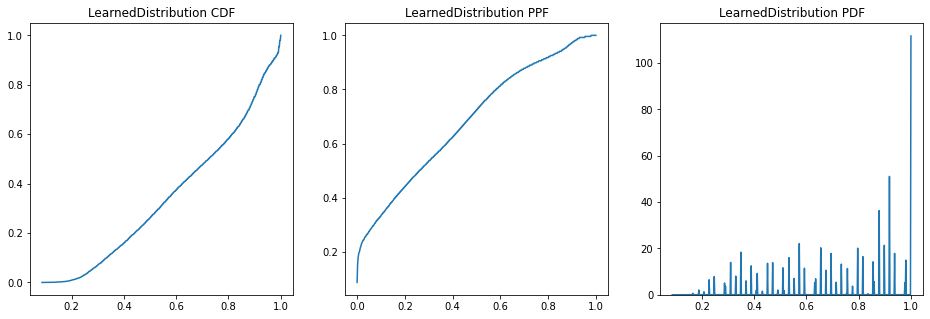

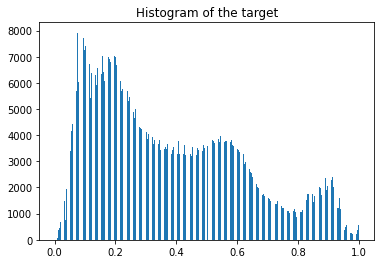

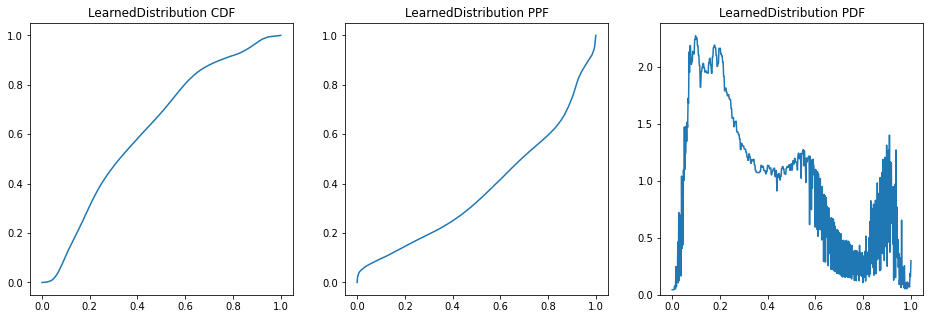

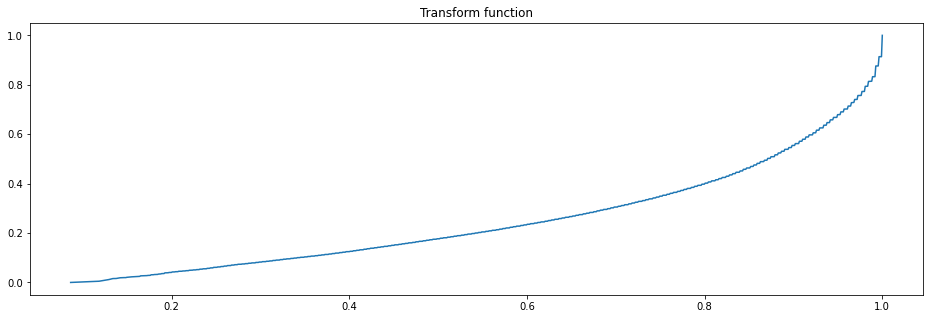

In [287]:
# Plot the learned functions
plt.hist(src.ravel(), bins=512, density=True)
plt.title('Histogram of the source')
plt.show(); plt.close()
cpp(r.source, bins=512)
plt.show(); plt.close()

plt.hist(dst.ravel(), bins=512)
plt.title('Histogram of the target')
plt.show(); plt.close()
cpp(r.target, bins=512)
plt.show(); plt.close()

r.plot_transform_function()

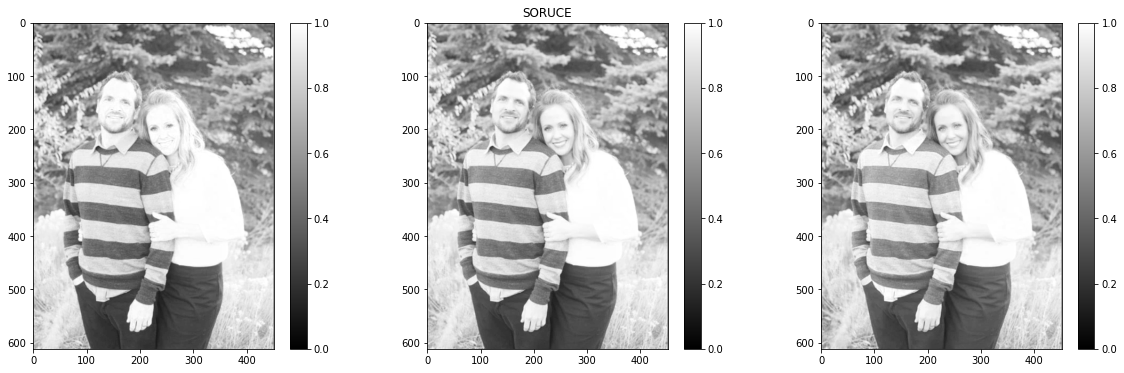

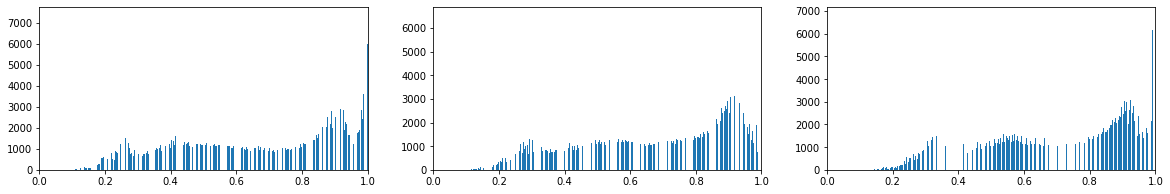

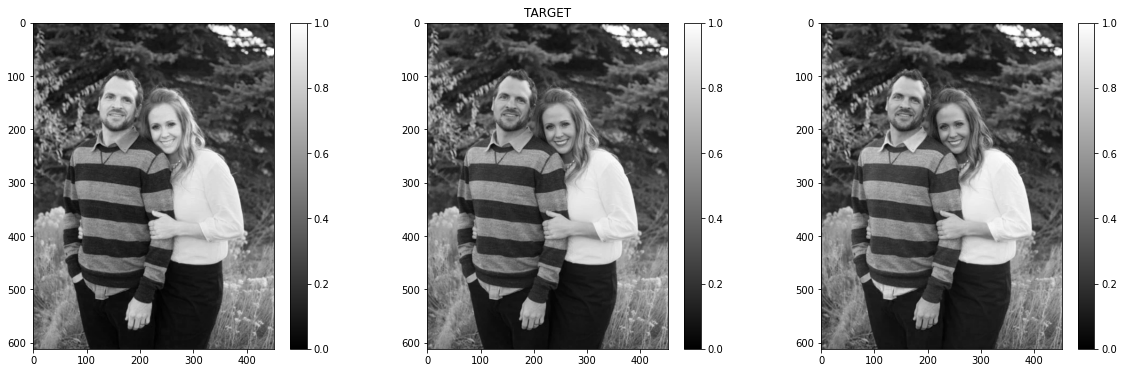

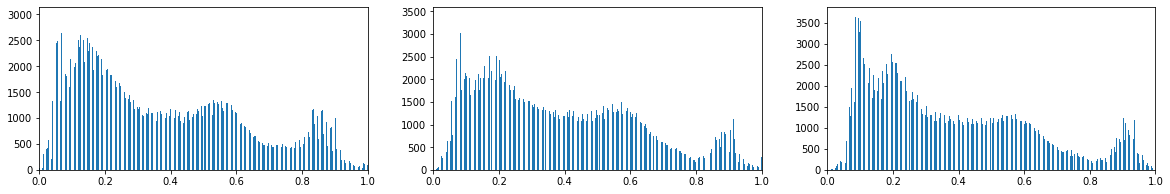

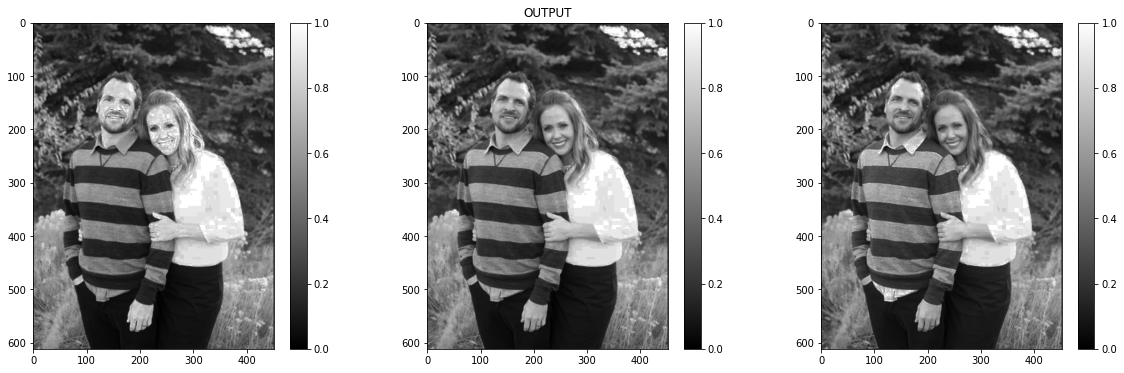

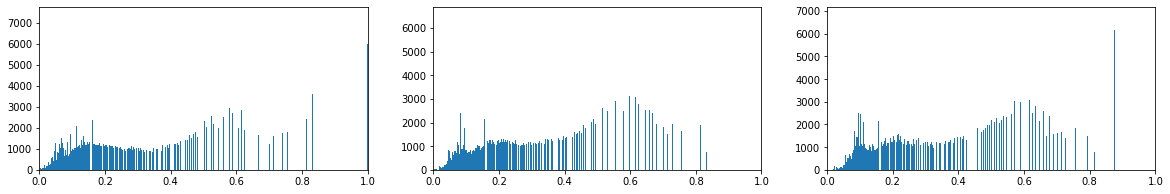

In [288]:
# Visualizing the histograms of src, dst and out per channel
bins=512

plt.figure(figsize=(20,6))
plt.subplot(131)
plt.imshow(src[roi][:,:,0])
plt.clim(0, 1)
plt.colorbar()
plt.subplot(132)
plt.title('SORUCE')
plt.imshow(src[roi][:,:,1])
plt.clim(0, 1)
plt.colorbar()
plt.subplot(133)
plt.imshow(src[roi][:,:,2])
plt.clim(0, 1)
plt.colorbar()

plt.figure(figsize=(20,3))
plt.subplot(131)
plt.hist(src[roi][:,:,0].ravel(), bins=bins)
plt.xlim(0, 1)
plt.subplot(132)
plt.hist(src[roi][:,:,1].ravel(), bins=bins)
plt.xlim(0, 1)
plt.subplot(133)
plt.hist(src[roi][:,:,2].ravel(), bins=bins)
plt.xlim(0, 1)



plt.figure(figsize=(20,6))
plt.subplot(131)
plt.imshow(dst[roi][:,:,0])
plt.clim(0, 1)
plt.colorbar()
plt.subplot(132)
plt.title('TARGET')
plt.imshow(dst[roi][:,:,1])
plt.clim(0, 1)
plt.colorbar()
plt.subplot(133)
plt.imshow(dst[roi][:,:,2])
plt.clim(0, 1)
plt.colorbar()

plt.figure(figsize=(20,3))
plt.subplot(131)
plt.hist(dst[roi][:,:,0].ravel(), bins=bins)
plt.xlim(0, 1)
plt.subplot(132)
plt.hist(dst[roi][:,:,1].ravel(), bins=bins)
plt.xlim(0, 1)
plt.subplot(133)
plt.hist(dst[roi][:,:,2].ravel(), bins=bins)
plt.xlim(0, 1)



plt.figure(figsize=(20,6))
plt.subplot(131)
plt.imshow(out[roi][:,:,0])
plt.clim(0, 1)
plt.colorbar()
plt.subplot(132)
plt.title('OUTPUT')
plt.imshow(out[roi][:,:,1])
plt.clim(0, 1)
plt.colorbar()
plt.subplot(133)
plt.imshow(out[roi][:,:,2])
plt.clim(0, 1)
plt.colorbar()

plt.figure(figsize=(20,3))
plt.subplot(131)
plt.hist(out[roi][:,:,0].ravel(), bins=bins)
plt.xlim(0, 1)
plt.subplot(132)
plt.hist(out[roi][:,:,1].ravel(), bins=bins)
plt.xlim(0, 1)
plt.subplot(133)
plt.hist(out[roi][:,:,2].ravel(), bins=bins)
plt.xlim(0, 1)
plt.show()

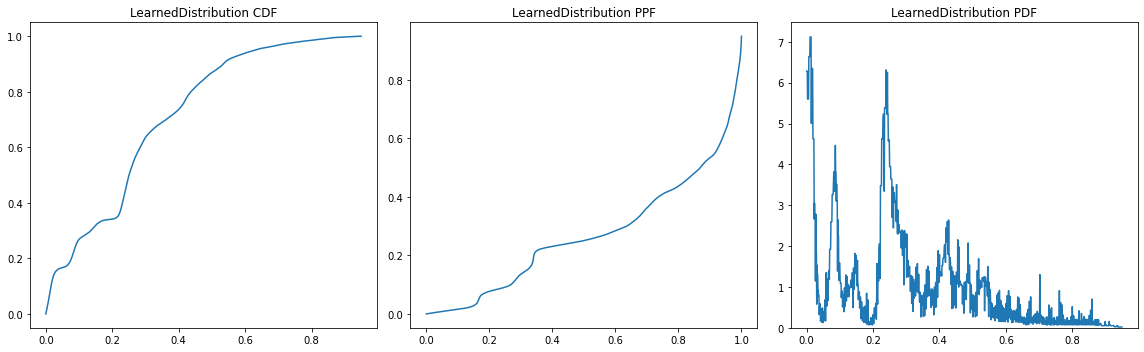

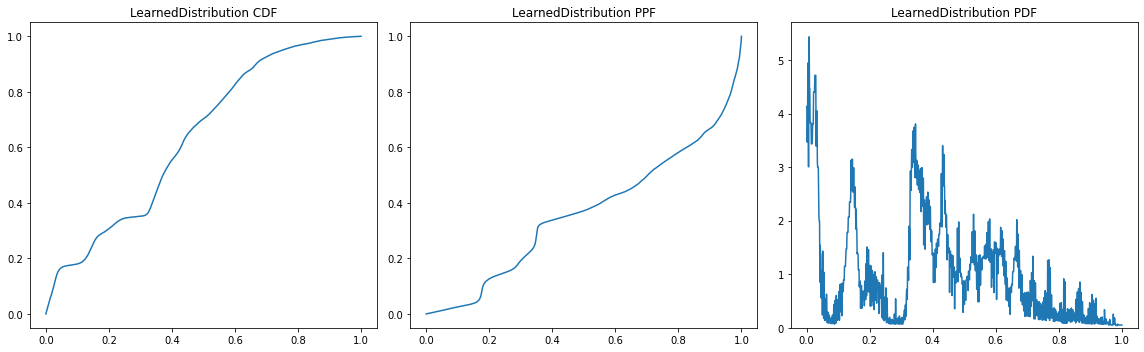

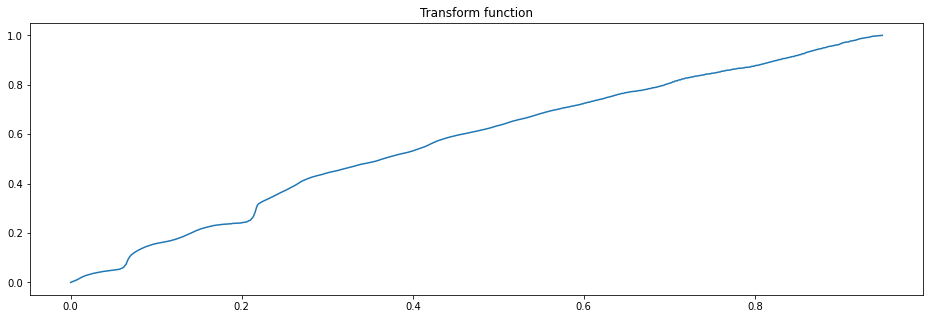

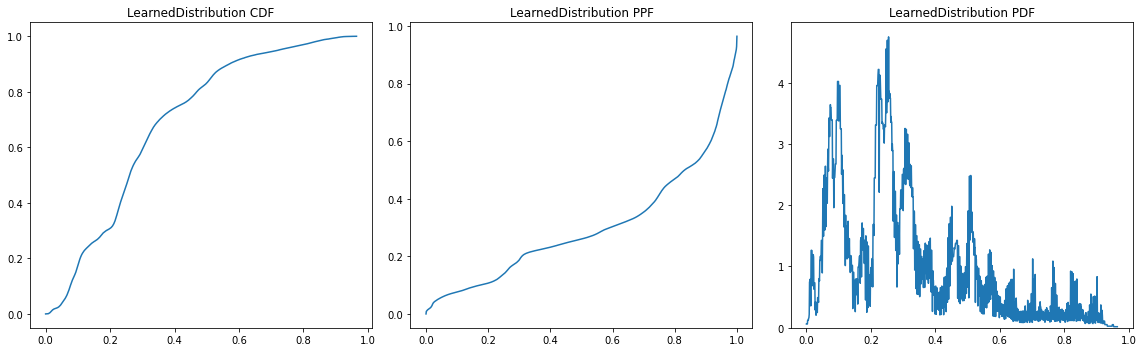

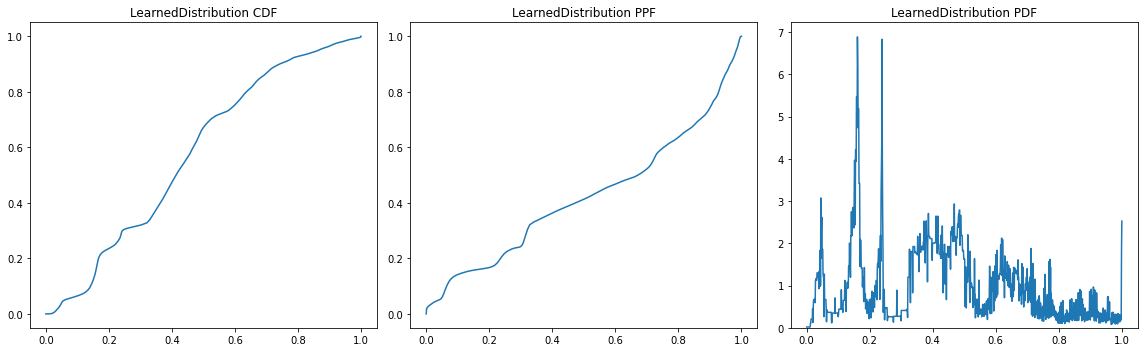

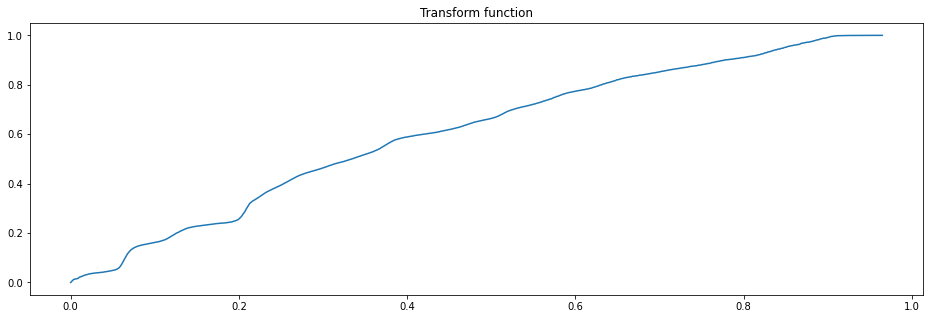

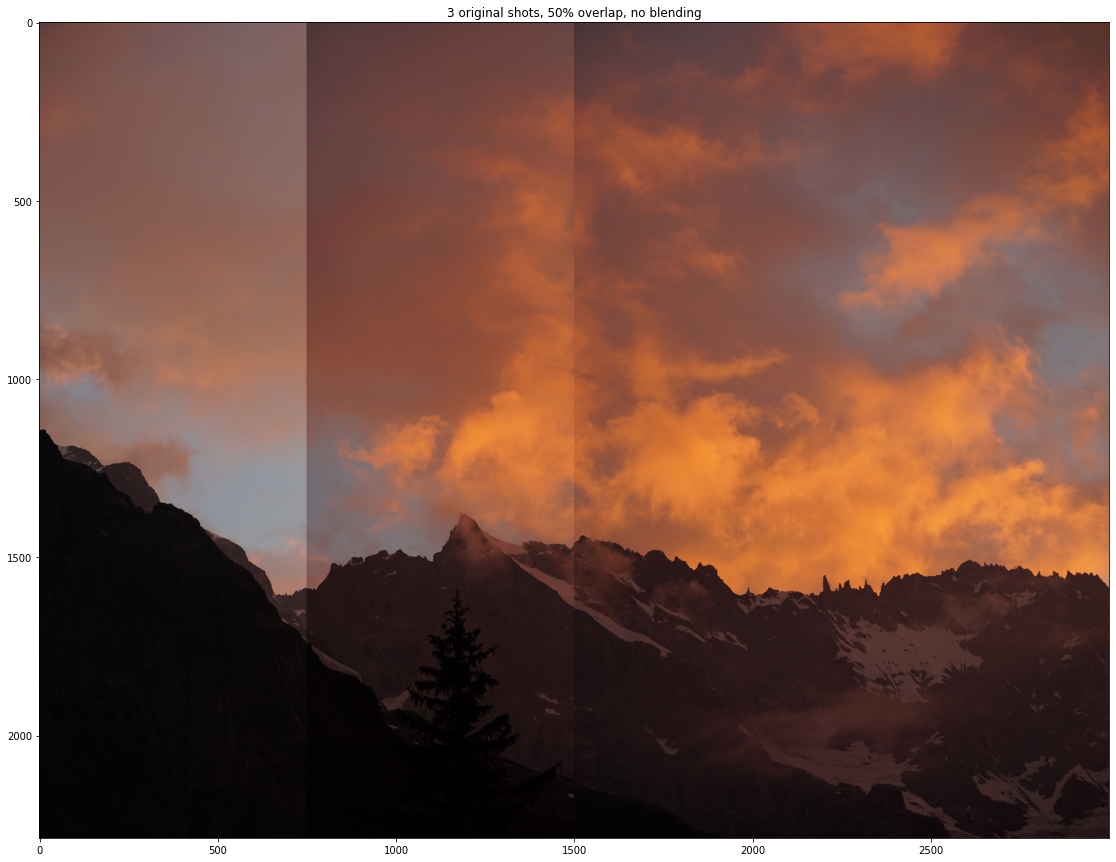

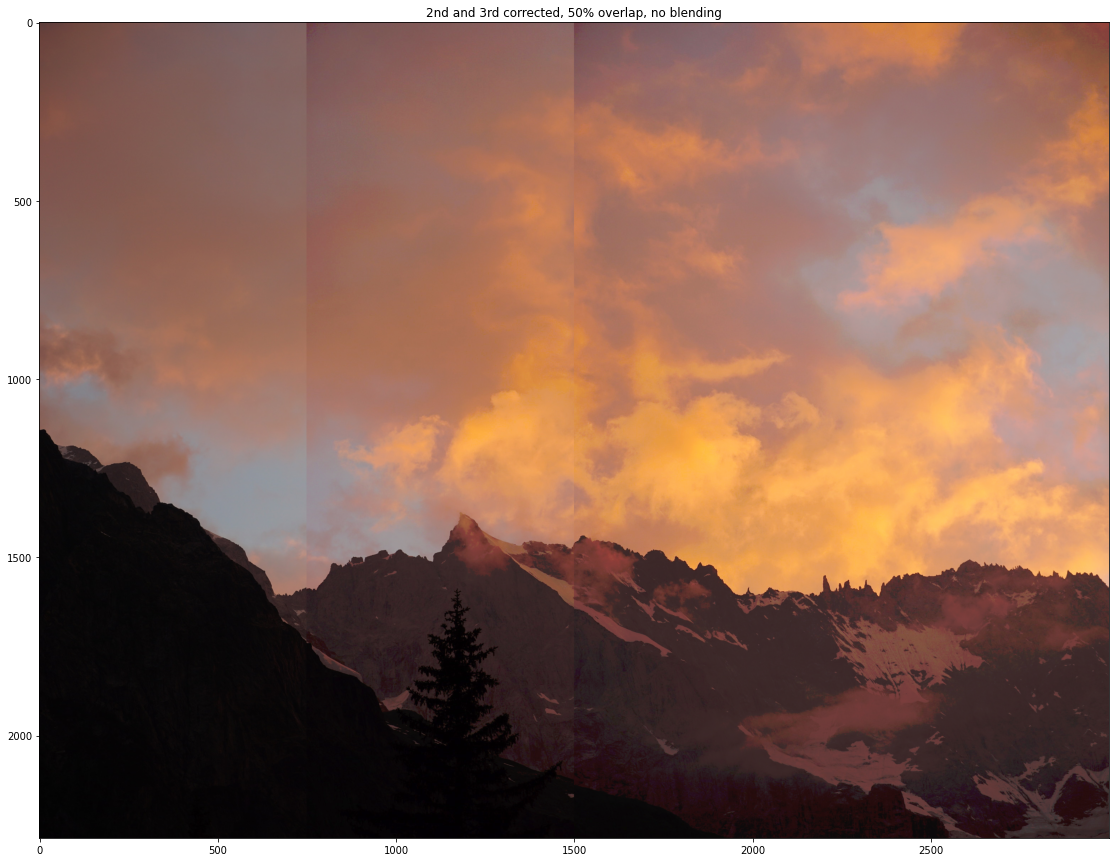

In [22]:
# https://www.dpreview.com/forums/thread/4297700
pano1 = plt.imread('aux/experiments/MatchColor/pano/1.png')
pano2 = plt.imread('aux/experiments/StyleTransfer/pano/2.png')
pano3 = plt.imread('aux/experiments/StyleTransfer/pano/3.png')
assert pano1.shape == pano2.shape == pano3.shape
shape = pano1.shape
overlap = 750
sr = (slice(None), slice(overlap, None))
sl = (slice(None), slice(None, overlap))

# All channels at once (Changing 2 and 3, i.e. 1 is the anchor)
what_to_plot = [2, 3]
r2 = R(source=L(x=pano2[sl].ravel()), target=L(x=pano1[sr].ravel()))
pano2_cor = r2.transform(pano2.ravel()).reshape(shape)
r3 = R(source=L(x=pano3[sl].ravel()), target=L(x=pano2_cor[sr].ravel()))
pano3_cor = r3.transform(pano3.ravel()).reshape(shape)

# All channels at once (Changing 1 and 3, i.e. 2 is the anchor)
what_to_plot = [1, 2]
r1 = R(source=L(x=pano1[sr].ravel()), target=L(x=pano2[sl].ravel()))
pano1_cor = r2.transform(pano1.ravel()).reshape(shape)
r3 = R(source=L(x=pano3[sl].ravel()), target=L(x=pano2[sr].ravel()))
pano3_cor = r3.transform(pano3.ravel()).reshape(shape)

if 1 in what_to_plot:
    # Plot the learned functions
    cpp(r1.source, bins=1000)
    cpp(r1.target, bins=1000)
    r1.plot_transform_function()

if 2 in what_to_plot:
    # Plot the learned functions
    cpp(r2.source, bins=1000)
    cpp(r2.target, bins=1000)
    r2.plot_transform_function()

if 3 in what_to_plot:
    # Plot the learned functions
    cpp(r3.source, bins=1000)
    cpp(r3.target, bins=1000)
    r3.plot_transform_function()

def stitch_hor(X, overlap):
    height = X[0].shape[0]
    out = np.zeros((height, overlap * len(X) + overlap, 3))
    for i, x in enumerate(X):
        out[:, i*overlap:(i+1)*overlap + overlap, :] = x
    return out
        
plt.figure(figsize=(30,15))
plt.title('3 original shots, 50% overlap, no blending')
plt.imshow(stitch_hor([pano1, pano2, pano3], overlap=overlap))
    
plt.figure(figsize=(30,15))
plt.title('2nd and 3rd corrected, 50% overlap, no blending')
plt.imshow(stitch_hor([pano1, pano2_cor, pano3_cor], overlap=overlap))

# plt.figure(figsize=(30,15))
# plt.title('1st and 3rd corrected, 50% overlap, no blending')
# plt.imshow(stitch_hor([pano1_cor, pano2, pano3_cor], overlap=overlap))
# plt.imsave('aux/experiments/StyleTransfer/pano/1_cor.png', pano1_cor)

plt.imsave('aux/experiments/StyleTransfer/pano/2_cor.png', pano2_cor)
plt.imsave('aux/experiments/StyleTransfer/pano/3_cor.png', pano3_cor)

## Work in progress

In [20]:
# source.badvalue

# source.cdf() # Implemented
# source.entropy()  # Implemented
# source.expect() # TODO implement or check if correct
# source.fit(x)  # Integration errors, check what it actually tries to do and whether it makes sense
# source.fit_loc_scale() # check what it actually tries to do and whether it makes sense
# source.freeze()
# source.generic_moment
# source.interval()
# source.isf()
# source.logcdf()
# source.logpdf()
# source.logsf()
# source.sf()
# source.mean()
# source.median()
# source.moment()
# source.moment_type()
# source.nnlf()
# source.numargs()
# source.pdf()
# source.shapes()
# source.stats()
# source.std()
# source.support()
# source.var()
# source.vecentropy()
# source.xtol